# Attending to the Disaster Tweets


![Attention Networks](https://www.asimovinstitute.org/wp-content/uploads/2019/04/AN-768x385.png)

## In this competition, we are challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified.


In [ ]:
# Import all essential packages keras, numpy, pandas, matplotlib, gensim 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re # Regular Expressions
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from keras.layers import LSTM
from keras.initializers import Constant
from keras.utils import to_categorical
from keras.models import Model
from keras import optimizers
from keras import backend as K



from gensim.parsing.preprocessing import remove_stopwords



import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Calculate F1:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val



# List Input Directories
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# Any results you write to the current directory are saved as output.


def make_embedding_dict(glove_embedding_file_path):
    embedding_dict={}
    with open(glove_embedding_file_path, 'r') as f:
        for line in tqdm(f.readlines()):
            values=line.split()
            word=values[0]
            vectors=np.asarray(values[1:],'float32')
            embedding_dict[word]=vectors
    return embedding_dict
#embeddings_index = make_embedding_dict('/kaggle/input/glove6b/glove.6B.300d.txt')
# embeddings_index = make_embedding_dict('/kaggle/input/glove-global-vectors-for-word-representation/glove.twitter.27B.200d.txt')
model = gensim.models.keyedvectors.Word2VecKeyedVectors.load_word2vec_format('/kaggle/input/glove-global-vectors-for-word-representation/glove.twitter.27B.200d.txt')

## Data Cleaning
One of the keys steps in every machine learning workflow is cleaning and organizing the dataset, we shall perform some basic processing of the data to be later used as input by all the models that we will later try out 

In [15]:
# Get rid of urls, hashtags, @usernames, emojis via regex
# References: https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python

emoji_pattern = emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
clean_pattern =  re.compile('<.*?>|^http?:\/\/.*[\r\n]*|#|@[^\s]+|http[s]?[^\s]+')
numeric_pattern = re.compile("[0-9]+")
punctuations_pattern = re.compile('[^\w\s]')
# html_pattern '<.*?>'
# url_pattern '^https?:\/\/.*[\r\n]*'
# hash_tags '#'
# username pattern ''@[^\s]+'
# Remove Numbers and complressed urls as such httpssampleurlstoremove using:
# [0-9]+|http[s]?[^\s]+

def clean_tweet(tweet):
    tweet = re.sub(emoji_pattern, '', tweet)
    tweet = re.sub(clean_pattern, '', tweet)
    # Instead of Discarding Numbers we merely replace it with the token 'number'
    tweet = re.sub(numeric_pattern, "number", tweet)
    tweet = re.sub(punctuations_pattern, '', tweet)
    tweet = tweet.lower()
    return tweet.strip()

example = """<div>
<h1>Real or Fake httpssampleurlstoremove </h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div> @remove_me and I don't like 2 many #tags and remove these 2emojis --> 😔😔"""
example = "Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all"
print(clean_tweet(example)) # no emoji

our deeds are the reason of this earthquake may allah forgive us all


In [ ]:
# Read and Preprocess the dataset 
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
print(train_df.shape, test_df.shape)

# Print Data Quality Stats 
train_df.isnull().sum()/train_df.shape[0]*100

# Preprocessing 
train_df['text_processed'] = train_df['text'].apply(lambda x: clean_tweet(x))
test_df['text_processed'] = test_df['text'].apply(lambda x: clean_tweet(x))
train_df['keyword'] = train_df['keyword'].apply(lambda x:" ".join(str(x).strip().split("%20")))
test_df['keyword'] = test_df['keyword'].apply(lambda x:" ".join(str(x).strip().split("%20")))
# Looks Like we happen to have a lot of nans in the keywords 
train_df.loc[train_df['keyword']=='nan','keyword'] = np.nan
test_df.loc[train_df['keyword']=='nan','keyword'] = np.nan

list(train_df[['text', 'text_processed']].sample(n=5).values)


# Analysis
Now that we have train and text data processed lets do some plots !!!

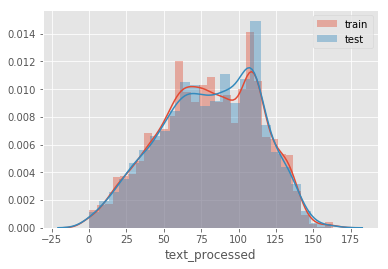

In [4]:
# Word Count Distributions 
sns.distplot(train_df['text_processed'].apply(lambda x:len(x)), label='train')
sns.distplot(test_df['text_processed'].apply(lambda x:len(x)), label = 'test')
plt.legend()

# looks like they belong to same gaussian distribution, 
# hence testset is a good representative of trainset

# This helps to set our max tweet length to 150
MAX_TWEET_LEN = 80 

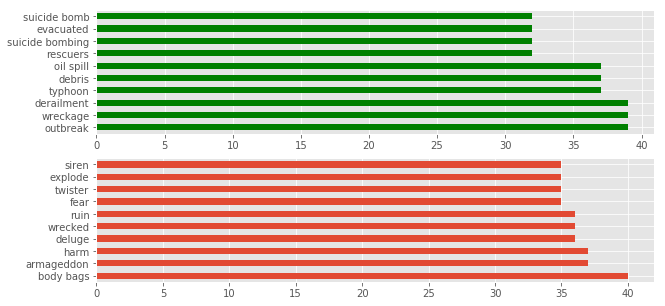

In [5]:
# Top Most common keywords
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(10,5))
# Keywords by Target 
train_df[train_df['target'] == 1]['keyword'].value_counts()[:10].plot(kind='barh', ax = ax1, color = 'green')
train_df[train_df['target'] == 0]['keyword'].value_counts()[:10].plot(kind='barh', ax = ax2)

# Looking at the plots, keywords can be very important when seperatig out 
# Disaster tweets

In [13]:
# Inspite of spell checks people tend to make mistakes. We try to fix as many as possible 
def spellcheck_tweet(tweet):
    tweet = tweet.split()
    for idx, word in enumerate(tweet):
        # Get the one `most likely` answer
        if word not in word_vectors.vocab:
            # Get a list of `likely` options
            correct_word = word_vectors.most_similar(word)
            print(word, correct_word)
            tweet[idx] = correct_word
    return " ".join(tweet)

train_df['text_processed'] = train_df['text_processed'].apply(lambda x: spellcheck_tweet(x))

KeyError: "word 'numbernumber' not in vocabulary"

#### Thats it for analysis, if you want more insights checkout other wonderful kernels for this competition 

# GloVe Word Embeddings
Any SOTA NLP algorithm these days converts every word to its vector respresentation, we will start with Pretrained Glove on Twitter Dataset, more information on pre training can be found [here](https://nlp.stanford.edu/projects/glove/). I have imported all the versions but we will be using 200 dimensional vector representations

GloVe is essentially a log-bilinear model with a weighted least-squares objective. The main intuition underlying the model is the simple observation that ratios of word-word co-occurrence probabilities have the potential for encoding some form of meaning. 

In [ ]:
# Lets Tokenize out train and test data 
# Define Out of Vocaboulary token 
# oov_token = "UNK"
EMBEDDING_DIM = 200
train_texts = train_df['text_processed'].to_list()
test_texts = test_df['text_processed'].to_list()


#Note: Fit the tokenizer only on Train and not on Test for obvious reasons :p
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)

# Transform text to sequences 
train_sequences = tokenizer.texts_to_sequences(train_texts)
train_sequences =pad_sequences(train_sequences, maxlen=MAX_TWEET_LEN ,truncating='post',padding='post')

test_sequences = tokenizer.texts_to_sequences(test_texts)
test_sequences =pad_sequences(test_sequences, maxlen=MAX_TWEET_LEN ,truncating='post',padding='post')

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# Create Embedding Matrix from Glove Words and Tokenizer Vocabulary
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
oov_tokens = []
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        oov_tokens.append(word)

print("Total Out of Vocabulary Words:",len(oov_tokens))

# Reference: https://keras.io/examples/pretrained_word_embeddings/
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(embedding_matrix.shape[0],
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_TWEET_LEN,trainable=False)

# Lstms &  Attention 

In [ ]:
print('Training a LSTM model...')
# 1D convnet with global maxpooling
sequence_input = Input(shape=(MAX_TWEET_LEN,), dtype='float32')
embedded_sequences = embedding_layer(sequence_input)
x = LSTM(16, return_sequences = False)(embedded_sequences)
x = Dense(8, activation='relu')(x)
x = Dense(4, activation='relu')(x)
preds = Dense(1, activation='sigmoid')(x)

adam = optimizers.Adam()

model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=[f1_score])
model.summary()

labels = train_df['target'].to_numpy()
model.fit(train_sequences, labels, validation_split=0.2,batch_size=256, epochs=3, verbose=1)

test_df['probs']  = model.predict(test_sequences)
test_df['target'] = (test_df['probs'] > 0.5).astype(int)
test_df[['id', 'target']].to_csv('submission.csv', index=False)
# Gets 0.77 interms of accuracy on leaderboard 

In [ ]:
test_df['probs']

### A simple 1D conv model with Global Max Pooling 

In [ ]:
print('Training a 1D conv model...')
# 1D convnet with global maxpooling
sequence_input = Input(shape=(MAX_TWEET_LEN,), dtype='float32')
embedded_sequences = embedding_layer(sequence_input)

x = Conv1D(64, 2, activation='relu')(embedded_sequences)
x = GlobalMaxPooling1D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.8)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.8)(x)
x = Dense(16, activation='relu')(x)
x = Dense(8, activation='relu')(x)
preds = Dense(1, activation='sigmoid')(x)

adam = optimizers.Adam()

model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=[f1_score])
model.summary()

labels = train_df['target'].to_numpy()
model.fit(train_sequences, labels, validation_split=0.1,batch_size=64, epochs=25, verbose=1)

test_df['probs']  = model.predict(test_sequences)
test_df['target'] = (test_df['probs'] > 0.5).astype(int)
test_df[['id', 'target']].to_csv('submission.csv', index=False)
# Gets 0.77 interms of accuracy on leaderboard 